In [1]:
# DICE SM - Exploration & Global Sensitivity Analysis
# Shridhar
#  saved 1428

  ## Setup & Initialisation of levers and uncertainties

In [107]:
import time

import matplotlib.pyplot as plt
from ema_workbench import (Model, RealParameter, IntegerParameter, ArrayOutcome, TimeSeriesOutcome,
                           ema_logging, SequentialEvaluator,
                           MultiprocessingEvaluator)
from ema_workbench import save_results, load_results
ema_logging.log_to_stderr(ema_logging.INFO)
# from ema_workbench.analysis import pairs_plotting
# from PyDICE_V4_array_outcome import PyDICE
from dicemodel.MyDICE_v3 import PyDICE

In [122]:

if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    

    model = PyDICE()
    dice_sm = Model('dicesmEMA', function=model)
    
    dice_sm.uncertainties = [IntegerParameter('t2xco2_index', 0, 999),
                             IntegerParameter('t2xco2_dist',0,2),

                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600)]
    
    dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('prtp_dam',  0.001, 0.015),
                      RealParameter('emuc',  0.5, 1.5),
                      RealParameter('emdd',  0.5, 1.5),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)]
    
    dice_sm.outcomes = [TimeSeriesOutcome('Atmospheric Temperature'),
                        TimeSeriesOutcome('Damages'),
                        TimeSeriesOutcome('Utility of Consumption'),
                        TimeSeriesOutcome('Savings rate'),
                        TimeSeriesOutcome('Disutility of Damage'),
                        TimeSeriesOutcome('Damage to output ratio'),
                        TimeSeriesOutcome('Welfare'),
                        TimeSeriesOutcome('Total Output')]
    
    
    n_scenarios = 100
    n_policies = 10


In [125]:
list(dice_sm.outcomes)

[TimeSeriesOutcome('Atmospheric Temperature'),
 TimeSeriesOutcome('Damages'),
 TimeSeriesOutcome('Utility of Consumption'),
 TimeSeriesOutcome('Savings rate'),
 TimeSeriesOutcome('Disutility of Damage'),
 TimeSeriesOutcome('Damage to output ratio'),
 TimeSeriesOutcome('Welfare'),
 TimeSeriesOutcome('Total Output')]

In [109]:
    start = time.time()
    with MultiprocessingEvaluator(dice_sm, n_processes=8) as evaluator:
        experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios,policies=n_policies)
    end = time.time()
    
    print('Experiment time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 10 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Experiment time is 5 mintues


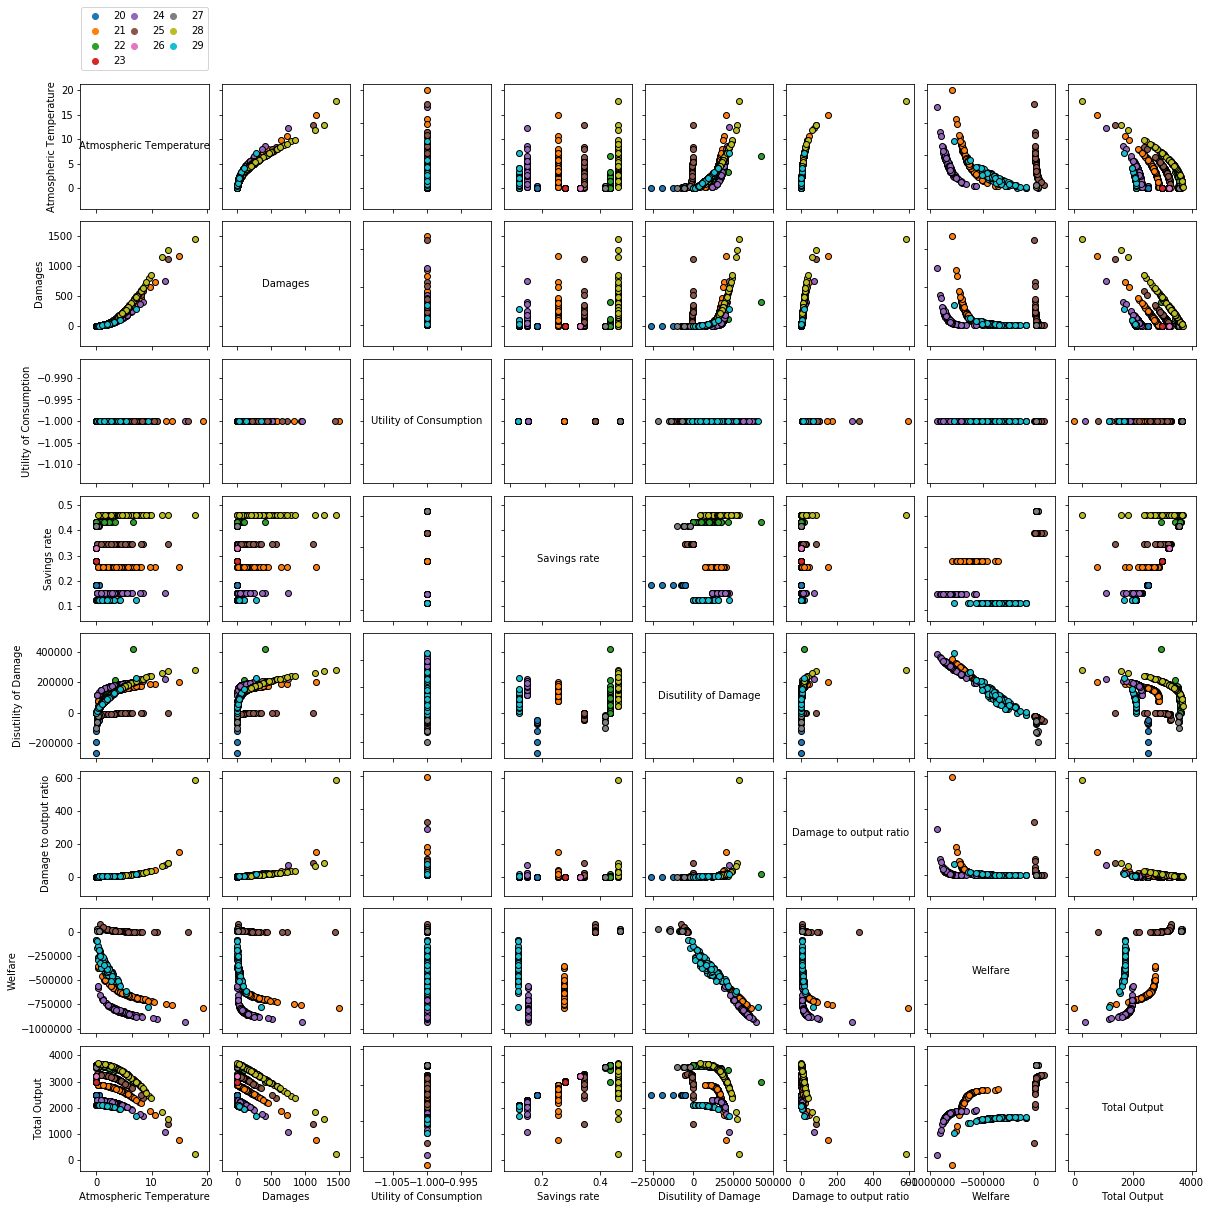

In [110]:
from ema_workbench.analysis import pairs_plotting
fig, axes = pairs_plotting.pairs_scatter(experiments,outcomes, group_by='policy',legend=True)
fig.set_size_inches(20,20)
plt.show()

In [137]:
experiments, outcomes = results

save_results(results, r'./1000 runs.tar.gz')
results

[MainProcess/INFO] results saved successfully to e:\Year_2_Quarter_4\Thesis\06_Code\noDICE\1000 runs.tar.gz


(     cback       fosslim    pop_gr  sigma_gr  t2xco2_dist  t2xco2_index  \
 0    159.0   5440.730690  0.119800 -0.010698          2.0         531.0   
 1    455.0   5187.422628  0.130765 -0.008080          0.0         642.0   
 2    152.0  13429.033241  0.139417 -0.011569          0.0          55.0   
 3    176.0   8246.563343  0.140531 -0.009016          1.0         800.0   
 4    173.0   7890.660260  0.127429 -0.010609          2.0         125.0   
 5    231.0   5996.149866  0.146785 -0.011686          0.0         501.0   
 6    246.0   7564.346420  0.129889 -0.010269          1.0          69.0   
 7    384.0  13521.392230  0.144089 -0.008853          1.0         386.0   
 8    340.0  11619.862638  0.135330 -0.009218          0.0         434.0   
 9    502.0   6878.336013  0.110820 -0.008338          0.0         327.0   
 10   380.0   6998.352155  0.100346 -0.010184          0.0         910.0   
 11   472.0  10456.838768  0.121716 -0.011826          0.0         652.0   
 12   520.0 

In [128]:
# transform the results to the required format (adapted from EMA workbench Mexican Flu example)
# that is, we want to know the max peak and the casualties at the end of the
# run
tr = {}


# get time and remove it from the dict
for key, value in outcomes.items():
    if key == 'Atmospheric temperature':
        tr[key] = value[:, -1]  # we want the end value
    else:
        # we want the maximum value of the peak
        max_peak = np.max(value, axis=1)
        tr['max peak'] = max_peak

        # we want the time at which the maximum occurred
        # the code here is a bit obscure, I don't know why the transpose
        # of value is needed. This however does produce the appropriate results
        logical = value.T == np.max(value, axis=1)
        tr['time of max'] = time[logical.T]

KeyError: 'TIME'

In [104]:
from ema_workbench.analysis import prim
from ema_workbench.analysis import scenario_discovery_util as sdutil
from sklearn import preprocessing 
import numpy as np
x = experiments
# outcome is nd-array, PRIM needs 1D

# y = outcomes['Atmospheric Temperature']
y = np.amax(outcomes['Atmospheric Temperature'], axis =1) 
y

array([ 3.52740167,  3.49102016,  3.09540374,  3.88879132,  2.09686166,
        2.75059787,  2.8422063 ,  3.7333176 ,  2.89057716,  1.03768638,
        3.5212701 ,  2.73472835,  3.02819471,  3.1601232 ,  1.06524023,
        3.58920225,  3.2081409 ,  3.04260852,  1.46615717,  0.8       ,
        2.96117971,  3.07017643,  3.05533256,  1.87659858,  3.42166379,
        3.14659872,  2.67206873,  2.49472486,  2.05128866,  2.12669329,
        2.77091445,  2.77672981,  0.8       ,  1.46858015,  3.18514196,
        3.39349654,  3.45277813,  2.47762096,  3.04793052,  2.74470468,
        2.21141148,  2.30542625,  3.42875484,  2.91719588,  3.53709341,
        2.44433171,  2.39847241,  1.96517108,  3.56535112,  2.25514931,
        1.01981562,  6.36771501,  1.04552567,  3.91253977,  1.68820582,
        2.58665676,  3.46220419,  2.52523966,  2.24149785,  3.67977114,
        4.3185884 ,  2.8181735 ,  3.75032124,  2.83703064,  2.93277493,
        1.88999101,  3.2013188 ,  1.6726458 ,  2.48726796,  2.72

In [105]:
# len(y)
y.shape

(1000,)

In [83]:
x.shape

(1000, 17)

In [9]:
x

,cback,fosslim,pop_gr,sigma_gr,t2xco2_dist,t2xco2_index,tfp_gr,emdd,emuc,miu_period,periodfullpart,prtp_con,prtp_dam,sr,scenario,policy,model
0,159.0,5440.730690,0.119800,-0.010698,2.0,531.0,0.083939,1.196032,1.445687,22.0,54.0,0.006694,0.002877,0.183362,0,0,dicesmEMA
1,455.0,5187.422628,0.130765,-0.008080,0.0,642.0,0.082917,1.196032,1.445687,22.0,54.0,0.006694,0.002877,0.183362,1,0,dicesmEMA
2,152.0,13429.033241,0.139417,-0.011569,0.0,55.0,0.079430,1.196032,1.445687,22.0,54.0,0.006694,0.002877,0.183362,2,0,dicesmEMA
3,176.0,8246.563343,0.140531,-0.009016,1.0,800.0,0.082747,1.196032,1.445687,22.0,54.0,0.006694,0.002877,0.183362,3,0,dicesmEMA
4,173.0,7890.660260,0.127429,-0.010609,2.0,125.0,0.083532,1.196032,1.445687,22.0,54.0,0.006694,0.002877,0.183362,4,0,dicesmEMA
5,231.0,5996.149866,0.146785,-0.011686,0.0,501.0,0.085657,1.196032,1.445687,22.0,54.0,0.006694,0.002877,0.183362,5,0,dicesmEMA
6,246.0,7564.346420,0.129889,-0.010269,1.0,69.0,0.086704,1.196032,1.445687,22.0,54.0,0.006694,0.002877,0.183362,6,0,dicesmEMA
7,384.0,13521.392230,0.144089,-0.008853,1.0,386.0,0.075227,1.196032,1.445687,22.0,54.0,0.006694,0.002877,0.183362,7,0,dicesmEMA
8,340.0,11619.862638,0.135330,-0.009218,0.0,434.0,0.078053,1.196032,1.445687,22.0,54.0,0.006694,0.002877,0.183362,8,0,dicesmEMA
9,502.0,6878.336013,0.110820,-0.008338,0.0,327.0,0.071634,1.196032,1.445687,22.0,54.0,0.006694,0.002877,0.183362,9,0,dicesmEMA


In [100]:
results_prim = experiments, outcomes
results_prim

# classify_prim = 'Atmospheric Temperature'
# classify_prim = y
classify_prim = np.amax(outcomes['Atmospheric Temperature'], axis =1) 
# classify_prim = outcomes['Atmospheric Temperature']
classify_prim

array([ 3.52740167,  3.49102016,  3.09540374,  3.88879132,  2.09686166,
        2.75059787,  2.8422063 ,  3.7333176 ,  2.89057716,  1.03768638,
        3.5212701 ,  2.73472835,  3.02819471,  3.1601232 ,  1.06524023,
        3.58920225,  3.2081409 ,  3.04260852,  1.46615717,  0.8       ,
        2.96117971,  3.07017643,  3.05533256,  1.87659858,  3.42166379,
        3.14659872,  2.67206873,  2.49472486,  2.05128866,  2.12669329,
        2.77091445,  2.77672981,  0.8       ,  1.46858015,  3.18514196,
        3.39349654,  3.45277813,  2.47762096,  3.04793052,  2.74470468,
        2.21141148,  2.30542625,  3.42875484,  2.91719588,  3.53709341,
        2.44433171,  2.39847241,  1.96517108,  3.56535112,  2.25514931,
        1.01981562,  6.36771501,  1.04552567,  3.91253977,  1.68820582,
        2.58665676,  3.46220419,  2.52523966,  2.24149785,  3.67977114,
        4.3185884 ,  2.8181735 ,  3.75032124,  2.83703064,  2.93277493,
        1.88999101,  3.2013188 ,  1.6726458 ,  2.48726796,  2.72

In [103]:
prim_setup = prim.setup_prim(results = results_prim, classify = classify_prim, threshold = 0.8)
# prim_setup = prim.setup_prim(x, classify = classify_prim, threshold = 0.8,**kwargs)


TypeError: unknown type for classify

In [106]:
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha = 0.1)
box1 = prim_alg.find_box()

AssertionError: 

In [85]:
box1.show_tradeoff()
plt.show()

NameError: name 'box1' is not defined